# Assignment 2: Naive Bayes [20 marks]

Student Name: Chaojun Tang

Student ID: 1323782

## General info

<b>Due date</b>: Friday, 2 September 2022, 5pm

<b>Submission method</b>: Canvas submission

<b>Submission materials</b>: completed copy of this iPython notebook

<b>Late submissions</b>: -10% per day up to 5 days (both weekdays and weekends count)
<ul>
    <li>one day late, -2.0;</li>
    <li>two days late, -4.0;</li>
    <li>three days late, -6.0;</li>
    <li>four days late, -8.0;</li>
    <li>five days late, -10.0;</li>
</ul>

<b>Marks</b>: 20% of mark for class. 

<b>Materials</b>: See [Using Jupyter Notebook and Python page](https://canvas.lms.unimelb.edu.au/courses/126693/pages/python-and-jupyter-notebooks?module_item_id=3950453) on Canvas (under Modules> Coding Resources) for information on the basic setup required for this class, including an iPython notebook viewer.If your iPython notebook doesn't run on the marker's machine, you will lose marks. <b> You should use Python 3</b>.  


<b>Evaluation</b>: Your iPython notebook should run end-to-end without any errors in a reasonable amount of time, and you must follow all instructions provided below, including specific implementation requirements and instructions for what needs to be printed (please avoid printing output we don't ask for). You should implement functions for the skeletons listed below. You may implement any number of additional (helper) functions. You should leave the output from running your code in the iPython notebook you submit, to assist with marking. The amount each section is worth is given in parenthesis after the instructions. 

You will be marked not only on the correctness of your methods, but also the quality and efficiency of your code: in particular, you should be careful to use Python built-in functions and operators when appropriate and pick descriptive variable names that adhere to <a href="https://www.python.org/dev/peps/pep-0008/">Python style requirements</a>. If you think it might be unclear what you are doing, you should comment your code to help the marker make sense of it. We reserve the right to deduct up to 4 marks for unreadable or excessively inefficient code.

7 of the marks available for this Project will be assigned to whether the five specified Python functions work in a manner consistent with the materials from COMP90049. Any other implementation will not be directly assessed (except insofar as it is required to make these five functions work correctly).

13 of the marks will be assigned to your responses to the questions, in terms of both accuracy and insightfulness. We will be looking for evidence that you have an implementation that allows you to explore the problem, but also that you have thought deeply about the data and the behaviour of the Naive Bayes classifier.

<b>Updates</b>: Any major changes to the assignment will be announced via Canvas. Minor changes and clarifications will be announced on the discussion board (Piazza -> Assignments -> A2); we recommend you check it regularly.

<b>Academic misconduct</b>: While you may discuss this homework in general terms with other students, it ultimately is still an individual task. Reuse of code or other instances of clear influence will be considered cheating. Please check the <a href="https://canvas.lms.unimelb.edu.au/courses/126693/modules#module_734188">CIS Academic Honesty training</a> for more information. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.

**IMPORTANT**

Please carefully read and fill out the <b>Authorship Declaration</b> form at the bottom of the page. Failure to fill out this form results in the following deductions: 
<UL TYPE=”square”>
<LI>missing Authorship Declaration at the bottom of the page, -10.0
<LI>incomplete or unsigned Authorship Declaration at the bottom of the page, -5.0
</UL>

## Part 1: Base code [7 marks]

Instructions
1. Do **not** shuffle the data set
2. Treat the features as nominal and use them as provided (e.g., do **not** convert them to other feature types, such as numeric ones). Implement a Naive Bayes classifier with appropriate likelihood function for the data.
3. You should implement the Naive Bayes classifier from scratch. Do **not** use existing implementations/learning algorithms. You must use epsilon smoothing strategy as discussed in the Naive Bayes lecture. 
4. Apart from the instructions in point 3, you may use libraries to help you with data reading, representation, maths or evaluation.
5. Ensure that all and only required information is printed, as indicated in the final three code cells. Failure to adhere to print the required information will result in **[-1 mark]** per case. *(We don't mind details like you print a list or several numbers -- just make sure the information is displayed so that it's easily accessible)*
6. Please place the jupyter notebook into the same folder as the input data.


In [918]:
import numpy as np
import pandas as pd

In [919]:
# This function should open a csv file and read the data into a useable format [0.5 mark]

def preprocess(filename):
    train_data = pd.read_csv(filename)

    # drop client ID & label
    train_label = train_data[train_data.columns[-1]]
    del train_data[train_data.columns.values[0]]
    del train_data[train_data.columns.values[-1]]

    # this is used to prevent extreme case happen in CV
    all_features = list(train_data.columns)
    all_labels = np.unique(train_label)

    return train_data, train_label, all_features, all_labels

In [920]:
# This function should build a supervised NB model [3 marks]
def train(train_data, train_label, all_features, all_labels):
    if not len(train_data) == len(train_label):
        print("file sizes differ, please check")
        return 0

    train_size = train_data.shape[0]
    features = all_features
    
    label_priors = {}
    pred_priors = {}
    likelihoods = {}

    # initial label_prior dict
    for label in np.unique(all_labels):
        label_priors.update({label: 0})   

    # initialization
    for feature in features:

        # initial likelihoods dict
        likelihoods[feature] = {}

        # initial prediction prior belief dict
        pred_priors[feature] = {}

        # for each feature, iterate over unique value of this set of feature
        for feat_val in np.unique(train_data[feature]):

            # iterate over each label
            for label in np.unique(all_labels):

                # initial likelihood dict
                likelihoods[feature].update({feat_val+'_'+label:0})

    # calculate label probability prior P(y)
    for label in np.unique(all_labels):
        label_count = sum(train_label == label)
        
        # i.e. {'yes': 0.88, 'no': 0.11}
        label_priors[label] = label_count / train_size
        

    # calculate likelihoods P(x|y)
    for feature in features:
        for label in np.unique(all_labels):
            label_count = sum(train_label == label)

            # each feature likelihood under this lable (yes or no) equals to all instances of this feature that is under this label (yes or no)
            # simple visualization:
            # - cross all other class row
            # - cross all other features column
            # count this valid column's values, put into a dict
            feat_likelihood = train_data[feature][train_label[train_label == label].index.values.tolist()].value_counts().to_dict()

            for feat_val, count in feat_likelihood.items():
                likelihoods[feature][feat_val + '_' + label] = count/label_count

    unique_labels = np.unique(all_labels)

    return features, unique_labels, label_priors, pred_priors, likelihoods


In [921]:
# This function should predict the class for a set of instances, based on a trained model [1.5 marks]
def predict(candidates, features, unique_labels, label_priors, pred_priors, likelihoods):
    
    results = []
    epsilon = 1e-6

    # for each candidate
    for candidate in candidates:
        
        candidate_probability = {}

        # either 'yes' or 'no' in this case
        for label in np.unique(unique_labels):

            # percentage of 'yes' or 'no'
            # log-transformation
            p_y = np.log(label_priors[label])

            # initial set
            p_x_y = 0

            # reverse processing to pair feature heading with candidate features
            for feat, feat_val in zip(features, candidate):

                # in CV, this could happen due small sample size
                if feat_val + '_' + label not in likelihoods[feat].keys():
                    a_likelihood = 0
                else:
                    a_likelihood = likelihoods[feat][feat_val + '_' + label]
                
                # smoothing
                if a_likelihood == 0:
                    a_likelihood = epsilon
                
                # log it
                a_likelihood = np.log(a_likelihood)
                p_x_y += a_likelihood

            # Bayes rule in log-transformation
            p_y_x = (p_x_y + p_y) # / (p_x) dont need it

            # add bayes probability to dict
            candidate_probability[label] = p_y_x
        
        prediction_label = max(candidate_probability, key = lambda x: candidate_probability[x])
        
        # append to result list
        results.append(prediction_label)

    return np.array(results), candidate_probability

In [922]:
# This function should evaluate a set of predictions [1 mark]

# 1-E evaluation
def evaluate(sample, prediction):
    if not len(sample) == len(prediction):
        print("file sizes differ, please check")
        return 0

    true = sum(prediction == sample)
    total = len(sample)
    accuracy = float(true)/float(total)
    return accuracy

In [923]:
from sklearn import metrics

# f1-score evaluation
def f_score_evaluate(sample, prediction):
    if not len(sample) == len(prediction):
        print("file sizes differ, please check")
        return 0
    return metrics.classification_report(sample, prediction, digits=3)

## Bank Marketing

In [924]:
# This cell should act as your "main" function where you call the above functions 
# on the full Bank Marketing data set, and print the evaluation score. [0.33 marks]

# First, read in the data and apply your NB model to the Bank Marketing data
train_data, train_label, all_features, all_labels = preprocess("bank-marketing.csv")
features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

# Second, print the full evaluation results from the evaluate() function
to_predict = np.array(train_data)
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)

print("1-E Accuracy: {}".format(evaluate(train_label, results)))
print("F-Score Accuracy:\n {}".format(f_score_evaluate(train_label, results)))

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized

print("Feature vectors of instances [0, 1, 2]: \n", "instance 1: ", train_data.loc[0].tolist(), "\n", "instance 2: ", train_data.loc[1].tolist(), "\n", "instance 3: ", train_data.loc[2].tolist())

print("\nNumber of instances (N): ", train_data.shape[0])
print("Number of features (F): ", len(train_data.columns))
print("Number of labels (L): ", len(np.unique(train_label)))

to_predict = np.array([train_data.iloc[train_data.shape[0]-3]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\n\nPredicted class probabilities for instance N-3: ", results_probability)
print("Predicted class for instance N-3: ", results[0])

to_predict = np.array([train_data.iloc[train_data.shape[0]-2]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-2: ", results_probability)
print("Predicted class for instance N-2: ", results[0])


to_predict = np.array([train_data.iloc[train_data.shape[0]-1]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-1: ", results_probability)
print("Predicted class for instance N-1: ", results[0])



1-E Accuracy: 0.8874142888741429
F-Score Accuracy:
               precision    recall  f1-score   support

          no      0.908     0.972     0.939      4000
         yes      0.525     0.242     0.331       521

    accuracy                          0.887      4521
   macro avg      0.716     0.607     0.635      4521
weighted avg      0.864     0.887     0.869      4521

Feature vectors of instances [0, 1, 2]: 
 instance 1:  ['unemployed', 'married', 'primary', 'no', 'no', 'no', 'cellular', 'oct', 'unknown'] 
 instance 2:  ['services', 'married', 'secondary', 'no', 'yes', 'yes', 'cellular', 'may', 'failure'] 
 instance 3:  ['management', 'single', 'tertiary', 'no', 'yes', 'no', 'cellular', 'apr', 'failure']

Number of instances (N):  4521
Number of features (F):  9
Number of labels (L):  2


Predicted class probabilities for instance N-3:  {'no': -6.7116077635370655, 'yes': -8.583110831432391}
Predicted class for instance N-3:  no

Predicted class probabilities for instance N-2:  

## Student

In [925]:
# This cell should act as your "main" function where you call the above functions 
# on the full Student data set, and print the evaluation score. [0.33 marks]

# First, read in the data and apply your NB model to the Student data

train_data, train_label, all_features, all_labels = preprocess("student.csv")
features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

# Second, print the full evaluation results from the evaluate() function
to_predict = np.array(train_data)
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)

print("1-E Accuracy: {}".format(evaluate(train_label, results)))
print("F-Score Accuracy:\n {}".format(f_score_evaluate(train_label, results)))

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized

print("Feature vectors of instances [0, 1, 2]: \n", "instance 1: ", train_data.loc[0].tolist(), "\n", "instance 2: ", train_data.loc[1].tolist(), "\n", "instance 3: ", train_data.loc[2].tolist())

print("\nNumber of instances (N): ", train_data.shape[0])
print("Number of features (F): ", len(train_data.columns))
print("Number of labels (L): ", len(np.unique(train_label)))

to_predict = np.array([train_data.iloc[train_data.shape[0]-3]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\n\nPredicted class probabilities for instance N-3: ", results_probability)
print("Predicted class for instance N-3: ", results[0])

to_predict = np.array([train_data.iloc[train_data.shape[0]-2]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-2: ", results_probability)
print("Predicted class for instance N-2: ", results[0])


to_predict = np.array([train_data.iloc[train_data.shape[0]-1]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-1: ", results_probability)
print("Predicted class for instance N-1: ", results[0])



1-E Accuracy: 0.48382126348228044
F-Score Accuracy:
               precision    recall  f1-score   support

           A      0.421     0.492     0.454        65
          A+      0.500     0.471     0.485        17
           B      0.447     0.375     0.408       112
           C      0.423     0.448     0.435       154
           D      0.526     0.552     0.539       201
           F      0.584     0.520     0.550       100

    accuracy                          0.484       649
   macro avg      0.484     0.476     0.478       649
weighted avg      0.486     0.484     0.483       649

Feature vectors of instances [0, 1, 2]: 
 instance 1:  ['GP', 'F', 'U', 'GT3', 'A', 'high', 'high', 'at_home', 'teacher', 'course', 'mother', 'medium', 'medium', 'none', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'good', 'mediocre', 'good', 'very_bad', 'very_bad', 'mediocre', 'four_to_six'] 
 instance 2:  ['GP', 'F', 'U', 'GT3', 'T', 'low', 'low', 'at_home', 'other', 'course', 'father', 'low',

## Obesity

In [926]:

# This cell should act as your "main" function where you call the above functions 
# on the full Obesity data set, and print the evaluation score. [0.33 marks]

# First, read in the data and apply your NB model to the Student data

train_data, train_label, all_features, all_labels = preprocess("obesity.csv")
features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

# Second, print the full evaluation results from the evaluate() function
to_predict = np.array(train_data)
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)

print("1-E Accuracy: {}".format(evaluate(train_label, results)))
print("F-Score Accuracy:\n {}".format(f_score_evaluate(train_label, results)))

# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of features, L the total number of labels
# The "class probabilities" may be unnormalized

print("Feature vectors of instances [0, 1, 2]: \n", "instance 1: ", train_data.loc[0].tolist(), "\n", "instance 2: ", train_data.loc[1].tolist(), "\n", "instance 3: ", train_data.loc[2].tolist())

print("\nNumber of instances (N): ", train_data.shape[0])
print("Number of features (F): ", len(train_data.columns))
print("Number of labels (L): ", len(np.unique(train_label)))

to_predict = np.array([train_data.iloc[train_data.shape[0]-3]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\n\nPredicted class probabilities for instance N-3: ", results_probability)
print("Predicted class for instance N-3: ", results[0])

to_predict = np.array([train_data.iloc[train_data.shape[0]-2]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-2: ", results_probability)
print("Predicted class for instance N-2: ", results[0])


to_predict = np.array([train_data.iloc[train_data.shape[0]-1]])
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
print("\nPredicted class probabilities for instance N-1: ", results_probability)
print("Predicted class for instance N-1: ", results[0])


1-E Accuracy: 0.7783041212695405
F-Score Accuracy:
               precision    recall  f1-score   support

   not-obese      0.868     0.694     0.772      1139
       obese      0.710     0.877     0.785       972

    accuracy                          0.778      2111
   macro avg      0.789     0.786     0.778      2111
weighted avg      0.795     0.778     0.778      2111

Feature vectors of instances [0, 1, 2]: 
 instance 1:  ['Male', 'yes', 'yes', 'mid', 'high', 'Sometimes', 'yes', 'mid', 'no', 'low-activity', 'mediocre', 'Frequently', 'Public_Transportation'] 
 instance 2:  ['Male', 'yes', 'yes', 'mid', 'high', 'Sometimes', 'no', 'high', 'no', 'low-activity', 'good', 'Sometimes', 'Public_Transportation'] 
 instance 3:  ['Male', 'yes', 'yes', 'high', 'high', 'Sometimes', 'no', 'high', 'no', 'low-activity', 'good', 'Sometimes', 'Public_Transportation']

Number of instances (N):  2111
Number of features (F):  13
Number of labels (L):  2


Predicted class probabilities for instance N

#### Part 2: Conceptual questions [13 marks]

## Question 1: One-R Baseline [3 marks]

In [927]:
# Write additional code here, if necessary (you may insert additional code cells)
# You should implement the One-R classifier from scratch. Do not use existing implementations/learning algorithms.
# Print the feature name and its corresponding error rate that One-R selects, in addition to any evaluation scores.

# One-r from scratch
def _one_r_predict(feature, train_data, train_label):
    value_count_dict = {}
    for value in np.unique(train_data[feature]):
        value_count_dict[value] = {}

        for label in np.unique(train_label):
            value_count_dict[value][label] = 0

    for label in np.unique(train_label):
        label_count_feature = train_data[feature][train_label[train_label == label].index.values.tolist()].value_counts().to_dict()
        
        for value in label_count_feature.keys():
            value_count_dict[value][label] = label_count_feature[value]

    train_size = train_data.shape[0]
    
    total_error = 0
    for value in value_count_dict.keys():
        dominate_label = max(value_count_dict[value], key = lambda x: value_count_dict[value][x])

        error_count = 0
        for label in value_count_dict[value].keys():
            if not label == dominate_label:
                error_count += value_count_dict[value][label]
        total_error += error_count

    return total_error / train_size

def one_r_predict(train_data, train_label):
        
    if not len(train_data) == len(train_label):
        print("file sizes differ, please check")
        return 0
        
    features = list(train_data.columns)
    one_r_dict = {}

    for feature in features:
        one_r_dict[feature] = _one_r_predict(feature, train_data, train_label)

    return one_r_dict

In [928]:
def get_one_r_predict_result(filename):
    print(filename + ": ")
    train_data, train_label, all_features, all_labels = preprocess(filename)
    features = list(train_data.columns)

    one_r_predict_result = one_r_predict(train_data, train_label)
    print("\nError rate:")
    # for feature in features:
        # print(feature, ": ", one_r_predict_result[feature])

    min = 1
    for feature in features:
        if one_r_predict_result[feature] < min:
            min = one_r_predict_result[feature]

    candidates_list = []
    for predict in one_r_predict_result.keys():
        if one_r_predict_result[predict] == min:
            candidates_list.append(predict)

    print("\nLowest error rate among features: ", min)
    print("Feature with min error rate: ", candidates_list)
    print("Equal accuracy: ", 1 - min, "\n")


In [929]:
files = []

files.append("bank-marketing.csv")
files.append("student.csv")
files.append("obesity.csv")

for file in files:
    get_one_r_predict_result(file)

bank-marketing.csv: 

Error rate:

Lowest error rate among features:  0.1070559610705596
Feature with min error rate:  ['poutcome']
Equal accuracy:  0.8929440389294404 

student.csv: 

Error rate:

Lowest error rate among features:  0.6656394453004623
Feature with min error rate:  ['Fedu']
Equal accuracy:  0.33436055469953774 

obesity.csv: 

Error rate:

Lowest error rate among features:  0.36475603979156795
Feature with min error rate:  ['family_history_with_overweight']
Equal accuracy:  0.6352439602084321 



Provide your text answer to **Question 1.b** of 100-150 words in this cell.

Naive bayes classifier accuracy of each dataset:

bank-marketing: 88.7%
student: 48.4%
obesity: 77.8%

One-r baseline accuracy of each dataset:

bank-marketing: 89.2%
student: 33.4%
obesity: 63.5%

Naive bayes classifier takes all features into consideration when making a prediction, hence, each feature no matter its contribution is high or low, will be considered to predict the class (although likelihood of each feature is different). One-r baseline consider each feature independently when making prediction, and choose the feature with highest accuracy rate, hence, One-r base is good at finding the dominant factor among all features. It can produce higher higher accuracy rate than naive bayes sometimes, if one feature dominates other features (in this situation, other features become drawbacks in predictions)

Referring to the student dataset, naive bayes classifier outperforms one-r base by a lot. In this case, no single feature contributes significant higher effect to results comparing to other features (error rate all among 0.66 to 0.69). Hence, naive bayes model carefully consider each feature, looking for the likelihoods of each feature and label and comprehensively predicting the result, while one-r could only pick the best among others. This is where naive bayes shines as it increases the accuracy from not-so-obvious dataset.

On the other hand, in the bank marketing dataset, one-r base performs slightly better than naive bayes. This shows that there must be one feature ("poutcome") that is highly related to the class label. If using naive bayes, it considers other not-so-related features which weigh down "poutcome" importance, hence the accuracy drops. Therefore, it means the effort spend on a sophisticated model (naive bayes) is probably not worth it as it doesn't outperform the baseline model result in this case.

## Question 2: Evaluation strategy [3 marks] 


In [930]:
# Write additional code here, if necessary (you may insert additional code cells)

# cv from scratch
def cv_preprocess(filename, m_partitions):
    train_data = pd.read_csv(filename)
    
    # delete client id
    del train_data[train_data.columns.values[0]]

    # drop client ID & label
    all_labels = np.unique(train_data[train_data.columns[-1]])

    all_features = list(train_data.columns)
    all_features.pop()

    permuted_indices = list(range(len(train_data)))

    feature_partitions = []
    label_partitions = []
    for i in range(m_partitions):
        one_partition = train_data.iloc[permuted_indices[i::m_partitions]]
        one_label_partition = one_partition[train_data.columns[-1]]
        del one_partition[one_partition.columns.values[-1]]
        
        feature_partitions.append(one_partition)
        label_partitions.append(one_label_partition)

    return feature_partitions, label_partitions, all_features, all_labels

In [931]:
def cross_validation(filename, m_partitions):
    feature_partitions, label_partitions, all_features, all_labels = cv_preprocess(filename, m_partitions)
    total_1E = 0
    total_F1 = 0
    for i in range(len(feature_partitions)):
        if m_partitions > 1:
            # pick one partition as test sample
            to_predict = np.array(feature_partitions[i])
            to_compare = label_partitions[i]

            # concat the rest as training sample
            _train_data = feature_partitions[0:i] + feature_partitions[i + 1 : len(feature_partitions)]
            train_data = pd.concat(_train_data)
            _train_label = label_partitions[0:i] + label_partitions[i + 1 : len(label_partitions)]
            train_label = pd.concat(_train_label)
        elif m_partitions == 1:
            to_predict = np.array(feature_partitions[0])
            to_compare = label_partitions[0]
            train_data = feature_partitions[0]
            train_label = label_partitions[0]
        else:
            print("m_partitions min 1")
            break
        
        # get 1-E
        features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)
        results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
        accuracy_1E = evaluate(to_compare, results)

        # get F-1
        total_1E += accuracy_1E
        report = metrics.classification_report(to_compare, results, output_dict=True, zero_division = 0)
        df_classification_report = pd.DataFrame(report).transpose()
        df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
        accuracy_F1 = df_classification_report["f1-score"]["weighted avg"]
        total_F1 += accuracy_F1

        print("Partition: ", i, "\t1-E Accuracy: ", accuracy_1E, "\tF1-score (weighted avg): ", df_classification_report["f1-score"]["weighted avg"])
    average_accuracy_1E = total_1E / m_partitions
    average_accuracy_F1 = total_F1 / m_partitions
    print("Average 1-E Accuracy: ", average_accuracy_1E)
    print("Average F1-score (weighted avg) accuracy: ", average_accuracy_1E)


In [932]:
m_partitions = 10

for file in files:
    print("Dataset: ", file)
    cross_validation(file, m_partitions)
    print()

Dataset:  bank-marketing.csv
Partition:  0 	1-E Accuracy:  0.869757174392936 	F1-score (weighted avg):  0.8507095257988332
Partition:  1 	1-E Accuracy:  0.8893805309734514 	F1-score (weighted avg):  0.8703183938816734
Partition:  2 	1-E Accuracy:  0.8915929203539823 	F1-score (weighted avg):  0.8760153110488978
Partition:  3 	1-E Accuracy:  0.8628318584070797 	F1-score (weighted avg):  0.8393810448850381
Partition:  4 	1-E Accuracy:  0.8716814159292036 	F1-score (weighted avg):  0.8442590936655259
Partition:  5 	1-E Accuracy:  0.9026548672566371 	F1-score (weighted avg):  0.8879627447199069
Partition:  6 	1-E Accuracy:  0.9026548672566371 	F1-score (weighted avg):  0.886873612975698
Partition:  7 	1-E Accuracy:  0.8960176991150443 	F1-score (weighted avg):  0.8752521823885979
Partition:  8 	1-E Accuracy:  0.8938053097345132 	F1-score (weighted avg):  0.8804647313739757
Partition:  9 	1-E Accuracy:  0.8783185840707964 	F1-score (weighted avg):  0.8592100500781867
Average 1-E Accuracy:  

Provide your text answer to **Question 2** 100-150 words in this cell.

From naive bayes classifier accuracy of each dataset:

bank-marketing: 88.7%
student: 48.4%
obesity: 77.8%

From question2, cross-fold evaluation

bank-marketing: 86.3% ~ 90.3%   Avg: 88.6%
student: 26.2% ~ 49.2%  Avg: 35.4%
obesity: 74.4% ~ 81.5%  Avg: 77.5%

From cross-fold evaluation (m = 10), bank-marketing's accuracy ranges from 86.3% to 90.3%, which matches to train on the whole dataset's accuracy 88.7%. Obesity's accuracy ranges from 74.4% to 81.5%, which matches to train on the whole dataset's accuracy 77.8%. The effectiveness does not change much whether train on whole set or using cross-fold, which indicate bias and variances are not much in those two dataset.

In comparison, student data set prediction accuracy drops to 24.6% ~ 40.0%, from 48.4%. This indicates that a high amount of bias or variances are among dataset. By using naive bayes model training on the whole set, we overfitting the model, which doesn't reveal the real predication accuracy rate to new data.

## Question 3: Feature Selection and Naive Bayes Assumptions [3 marks]

In [933]:
# Write additional code here, if necessary (you may insert additional code cells)

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [934]:
def mutual_information(filename):
    train_data = pd.read_csv(filename)
    # cat_cols = train_data.select_dtypes(include = ["object"]).columns
    
    # encode string to int
    to_encode = train_data.copy()
    for feature,value in to_encode.iteritems():
        to_encode[feature] = LabelEncoder().fit_transform(value)
    encoded_train_data = to_encode

    # drop client ID & label
    encoded_train_data_label = encoded_train_data[encoded_train_data.columns[-1]]
    del encoded_train_data[encoded_train_data.columns.values[0]]
    del encoded_train_data[encoded_train_data.columns.values[-1]]

    mutual_info = mutual_info_classif(encoded_train_data, encoded_train_data_label, discrete_features=True)
    mutual_info = pd.Series(mutual_info)
    mutual_info.index = encoded_train_data.columns

    return mutual_info


In [935]:
# evaluate result from top half feature
def result_select_top_half(top_half_index, filename):
    train_data = pd.read_csv(filename)

    # drop client ID & label
    train_label = train_data[train_data.columns[-1]]
    del train_data[train_data.columns.values[0]]
    del train_data[train_data.columns.values[-1]]

    for feature in train_data.columns:
        if feature not in top_half_index:
            del train_data[feature]

    all_features = list(train_data.columns)
    all_labels = np.unique(train_label)

    features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

    # Second, print the full evaluation results from the evaluate() function
    to_predict = np.array(train_data)
    results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
    return evaluate(train_label, results)

# evaluate result from bot half feature
def result_delete_top_half(top_half_index, filename):
    train_data = pd.read_csv(filename)

    # drop client ID & label
    train_label = train_data[train_data.columns[-1]]
    del train_data[train_data.columns.values[0]]
    del train_data[train_data.columns.values[-1]]

    for feature in train_data.columns:
        if feature in top_half_index:
            del train_data[feature]

    # print(train_data)
    all_features = list(train_data.columns)
    all_labels = np.unique(train_label)

    features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

    # Second, print the full evaluation results from the evaluate() function
    to_predict = np.array(train_data)
    results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)
    return evaluate(train_label, results)

# evaluate result from all feature
def result_all_feature(filename):
    train_data, train_label, all_features, all_labels = preprocess(filename)
    features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

    # Second, print the full evaluation results from the evaluate() function
    to_predict = np.array(train_data)
    results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)

    return evaluate(train_label, results)

<AxesSubplot:>

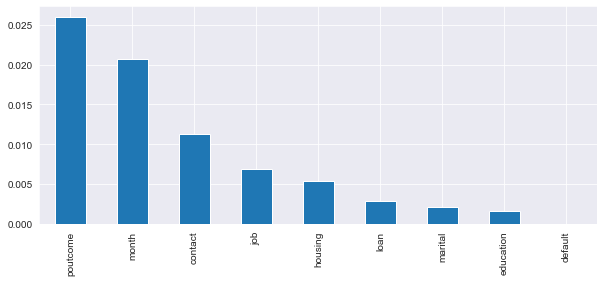

In [936]:
filename = "bank-marketing.csv"
mutual_info = mutual_information(filename)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4))

[0.8878566688785667, 0.8847600088476001, 0.8874142888741429]


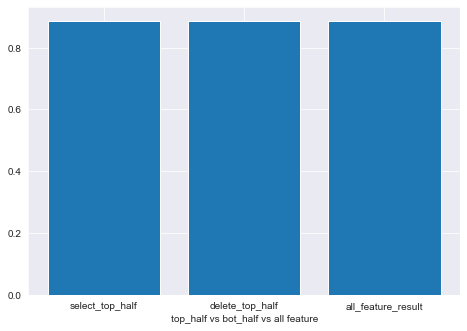

In [937]:
import matplotlib.pyplot as plt
top_half_index = mutual_info.sort_values(ascending=False).index[0:round(len(mutual_info)/2)]
# print(top_half_index)
select_half_result = result_select_top_half(top_half_index, filename)
delete_half_result = result_delete_top_half(top_half_index, filename)
all_feature_result = result_all_feature(filename)

cat = ['select_top_half', 'delete_top_half', 'all_feature_result']
score = [select_half_result, delete_half_result, all_feature_result]
print(score)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cat,score)
plt.xlabel("top_half vs bot_half vs all feature")
plt.show()

<AxesSubplot:>

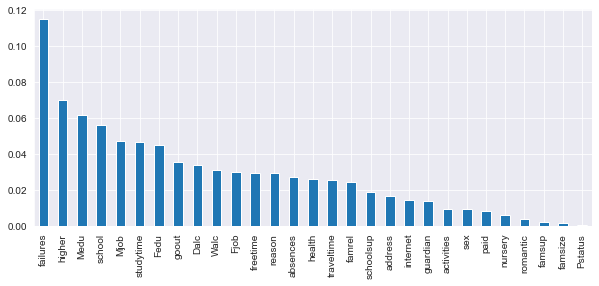

In [938]:
filename = "student.csv"
mutual_info = mutual_information(filename)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4))

[0.4391371340523883, 0.3913713405238829, 0.48382126348228044]


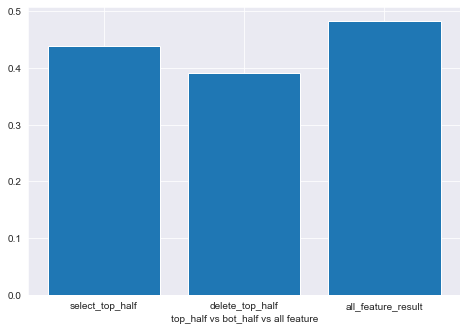

In [939]:
top_half_index = mutual_info.sort_values(ascending=False).index[0:round(len(mutual_info)/2)]
# print(top_half_index)
select_half_result = result_select_top_half(top_half_index, filename)
delete_half_result = result_delete_top_half(top_half_index, filename)
all_feature_result = result_all_feature(filename)

cat = ['select_top_half', 'delete_top_half', 'all_feature_result']
score = [select_half_result, delete_half_result, all_feature_result]
print(score)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cat,score)
plt.xlabel("top_half vs bot_half vs all feature")
plt.show()

<AxesSubplot:>

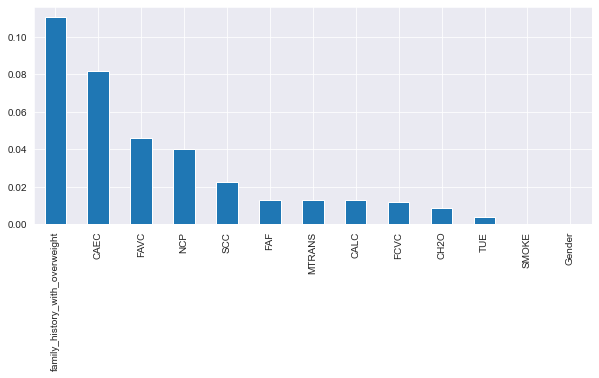

In [940]:
filename = "obesity.csv"
mutual_info = mutual_information(filename)
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4))

[0.7839886309805779, 0.6110847939365229, 0.7783041212695405]


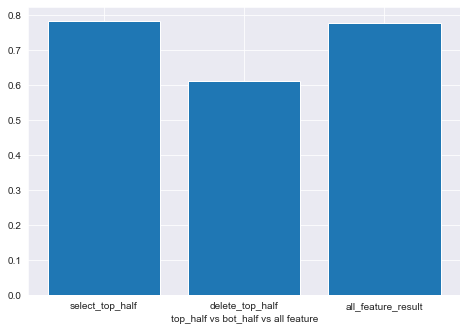

In [941]:
top_half_index = mutual_info.sort_values(ascending=False).index[0:round(len(mutual_info)/2)]
# print(top_half_index)
select_half_result = result_select_top_half(top_half_index, filename)
delete_half_result = result_delete_top_half(top_half_index, filename)
all_feature_result = result_all_feature(filename)

cat = ['select_top_half', 'delete_top_half', 'all_feature_result']
score = [select_half_result, delete_half_result, all_feature_result]
print(score)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(cat,score)
plt.xlabel("top_half vs bot_half vs all feature")
plt.show()

Provide your text answer to **Question 3.a** of 100-150 words in this cell.

From obesity's mutual info bar chart, it is clear that ["family_history_with_overweight"] has a much high number than others, suggesting this feature is more related the class label. ["smoke"] and ["gender"] are very close to 0, suggesting that these two features have no relation to its class label.

With this assumption, another bar chart, obesity's "top_half vs bot_half vs all feature" is shown above. It compares the accuracy rate from three train samples: 
    1) one sample that only keep the half top ranked feature in mutual info bar chart, 
    2) one sample that delete the half top ranked feature in mutual info bar chart, 
    3) and, the original sample.  
the results are 0.784, 0.611, 0.778 respectively. 



In student's mutual info bar chart, it is clear that ["failure"] has a much high number than others, suggesting this feature is more related the class label. ["famsupt"] and ["famsize"] are very close to 0, suggesting that these two features have much less relation to its class label.

With this assumption, another bar chart, student's "top_half vs bot_half vs all feature" is shown above. It compares the accuracy rate from three train samples: 
    1) one sample that only keep the half top ranked feature in mutual info bar chart, 
    2) one sample that delete the half top ranked feature in mutual info bar chart, 
    3) and, the original sample.  
the results are 0.439, 0.391, 0.484 respectively. 

Both example proves that the features with higher mutual information score have higher influence in predicting correct, while features with lower mutual information score have lower influence in correct prediction. 

One use case of this is eliminating low mutual information score feature, so the computation power needed are less while the accuracy remain the same.

Provide your text answer to **Question 3.b** of 100-150 words in this cell.

Why necessary:

Naive bayes make an outrages assumption that each feature is independent to others, which is rarely happening in real life. This limits its applicability in real-word use, however it makes the needed computational power become much less, so we can have the predication result quickly in an affordable time. Without the "naive" process, some prediction could be infeasible. Also, it makes assumptions about data probability distribution (prior-belief), whether it is gaussian distribution or Bernoulli distribution, this assumption works well when train from small sample of data, but nevertheless, it is a manually-made assumption.

When problematic:

1) In naive bayes, a major assumption is that features are conditionally independent to each other. It can be problematic when two or more features are closely related to  each other. In this situation, those features are processed with high bias and the performance (accuracy) could be low for new data. 
   
One example is that in student dataset, the accuracy for selecting high MI-score(mutual information) features dropped, compare to bank-marketing & obesity where the accuracy (for top MI-score features) remain the same level. This indicates that some features (in student dataset) in the low MI-score, are correlated to features with high MI-score. When calculating them together, the accuracy is 48.4%. However, we have proved that in cross-folding, the accuracy should be around 35.4%. Hence, this variance of performance is caused by feature dependency.

2) Another example when naive bayes can be problematic is data probability distribution (prior-belief). In bank-marketing, the labels are 4000 to 521. By using naive bayes mode, we assumed that new data come in with have the same distribution as the training sample, but this is not a case that will hold true all the time. Vice versa, in obesity we assumed the distribution of obesity vs none-obesity is around 50-50, but in real life the numbers are different.

3) It can also be problematic when the size of classes is big, or the number of categorical values of feature is high. For example, if taking clientID as one feature, the accuracy will be off by a lot. This problem is not shown in these test cases.

## Question 4: Feature Selection and Ethics [4 marks]

In [942]:
# Write additional code here, if necessary (you may insert additional code cells)

# ethic process student.csv file
train_data = pd.read_csv("student.csv")

# drop client ID & label
train_label = train_data[train_data.columns[-1]]
del train_data[train_data.columns.values[0]]
del train_data[train_data.columns.values[-1]]

del train_data["sex"]
del train_data["address"]
del train_data["famsize"]
del train_data["Pstatus"]
del train_data["Medu"]
del train_data["Fedu"]
del train_data["Mjob"]
del train_data["Fjob"]
del train_data["guardian"]
del train_data["traveltime"]
del train_data["nursery"]
del train_data["internet"]
del train_data["romantic"]
del train_data["famrel"]
del train_data["freetime"]
del train_data["goout"]
del train_data["Dalc"]
del train_data["Walc"]

all_features = list(train_data.columns)
all_labels = np.unique(train_label)

features, unique_labels, label_priors, pred_priors, likelihoods = train(train_data, train_label, all_features, all_labels)

# Second, print the full evaluation results from the evaluate() function
to_predict = np.array(train_data)
results, results_probability = predict(to_predict, features, unique_labels, label_priors, pred_priors, likelihoods)

print("1-E Accuracy: {}".format(evaluate(train_label, results)))
print("F-Score Accuracy:\n {}".format(f_score_evaluate(train_label, results)))

1-E Accuracy: 0.44684129429892144
F-Score Accuracy:
               precision    recall  f1-score   support

           A      0.286     0.031     0.056        65
          A+      0.200     0.059     0.091        17
           B      0.371     0.438     0.402       112
           C      0.412     0.500     0.452       154
           D      0.478     0.547     0.510       201
           F      0.580     0.510     0.543       100

    accuracy                          0.447       649
   macro avg      0.388     0.347     0.342       649
weighted avg      0.433     0.447     0.426       649



Provide your text answer to **Question 4.a** of 100-150 words in this cell.

In consideration of admitting a student based on their predicted grade, it is not ethical to discriminate certain features with/without knowing if the feature could affect the prediction of grade. For example, sex should have not be selected as a feature in predication. Even if sex does cause a difference on prediction result, it should be excluded as it causes sexism. Similar reasons apply to address, parent status etc. Those features are out of candidates' control and they should cause no differences on predicting one's grade. Otherwise, it creates advantages/disadvantages to certain candidates which is not fair and not ethically correct.


Provide your text answer to **Question 4.b** of 100-150 words in this cell.

After removing unethical features ["sex"]["address"]["Pstatus"]["Medu"]["Fedu"]["Mjob"]["Fjob"]["guardian"]["traveltime"]["internet"]
["romantic"]["famrel"]["freetime"]["nursery"]["freetime"]["goout"]["Dalc"]["Walc"], the accuracy rate dropped form 48.4% to 44.7%.

This indicates that those features do have an impact on predict one's grade, which means they cause some kine of bias or discrimination.Ethically, this should not be allowed. Even if it has an impact on prediction, we should eliminate it from our prediction.

Provide your text answer to **Question 4.c** of 100-150 words in this cell.

Removing all problematic features cannot guarantee a fair classifier. Fairness is very difficult to justify. For example, some student come from a rich family that support her/his life and education. Although we could remove features such as ["father job"] ["mother job"], the impact of this feature could reach others such as ["free time"] ["study time"] (doesn't need to work part-time), or ["school"], which could affect one's grade. 

Another example, sex shouldn't affect us predicting the grades. However, in situation, women can be more/less compatible then men by educational choices along the way. In this situation, although the sex group size distribution of sample data are equal (50:50), it doesn't represent that in one subject, the amount of men with classified under one label is equal to the amount of women classified under the same label.

And there is always data sample differences.

That said, we have to accept a truth that everyone's different, and a true fairness is very difficult to reach in feature selection. Machine learning doesn't understand context, and the context of fairness is always complicated.

<b>Authorship Declaration</b>:

   (1) I certify that the program contained in this submission is completely
   my own individual work, except where explicitly noted by comments that
   provide details otherwise.  I understand that work that has been developed
   by another student, or by me in collaboration with other students,
   or by non-students as a result of request, solicitation, or payment,
   may not be submitted for assessment in this subject.  I understand that
   submitting for assessment work developed by or in collaboration with
   other students or non-students constitutes Academic Misconduct, and
   may be penalized by mark deductions, or by other penalties determined
   via the University of Melbourne Academic Honesty Policy, as described
   at https://academicintegrity.unimelb.edu.au.

   (2) I also certify that I have not provided a copy of this work in either
   softcopy or hardcopy or any other form to any other student, and nor will
   I do so until after the marks are released. I understand that providing
   my work to other students, regardless of my intention or any undertakings
   made to me by that other student, is also Academic Misconduct.

   (3) I further understand that providing a copy of the assignment
   specification to any form of code authoring or assignment tutoring
   service, or drawing the attention of others to such services and code
   that may have been made available via such a service, may be regarded
   as Student General Misconduct (interfering with the teaching activities
   of the University and/or inciting others to commit Academic Misconduct).
   I understand that an allegation of Student General Misconduct may arise
   regardless of whether or not I personally make use of such solutions
   or sought benefit from such actions.

   <b>Signed by</b>: Chaojun Tang 1323782
   
   <b>Dated</b>: 2th September 2022